In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import json
import cv2
import matplotlib.pyplot as plt
from keras import backend as K
import os, shutil
import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# original_dataset_dir = '/content/drive/MyDrive/Colab Notebooks/Магистратура/dataset'

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Магистратура/dataset/Сегментация'
# os.mkdir(base_dir)

In [ ]:
# %%time
# for no in [str(x) for x in np.arange(15)]:
#   dir = os.path.join(original_dataset_dir, no)
#   fnames = ['{}'.format(i) for i in os.listdir(dir)]
#   for fname in fnames:
#     src = os.path.join(os.path.join(dir, fname))
#     dst = os.path.join(base_dir, fname)
#     shutil.copyfile(src, dst)

In [ ]:
len(os.listdir(base_dir))

9000

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Магистратура/dataset/Разметка_23042022.xlsx').sort_values('filename')

df.head()

,filename,region_shape_attributes,region_attributes
75,001b563d-e3f8-4d7c-9237-4f4ffd635f89.jpg,"{""name"":""rect"",""x"":394,""y"":1630,""width"":220,""h...","{""товар"":""цена""}"
1905,001b563d-e3f8-4d7c-9237-4f4ffd635f89.jpg,"{""name"":""rect"",""x"":135,""y"":1451,""width"":497,""h...","{""товар"":""ценник""}"
5318,001b563d-e3f8-4d7c-9237-4f4ffd635f89.jpg,"{""name"":""rect"",""x"":150,""y"":217,""width"":988,""he...","{""товар"":""эрмигурт""}"
1593,0035be71-7b62-4a01-ad6e-8d52ea26fe81.jpg,"{""name"":""rect"",""x"":600,""y"":2201,""width"":307,""h...","{""товар"":""цена""}"
3785,0035be71-7b62-4a01-ad6e-8d52ea26fe81.jpg,"{""name"":""rect"",""x"":34,""y"":20,""width"":1422,""hei...","{""товар"":""пепси 0,5л""}"


In [ ]:
df.shape[0]

5508

In [ ]:
df['region_attributes'].value_counts()

{"товар":"цена"}              1834
{"товар":"ценник"}            1791
{"товар":"пепси 0,5л"}         201
{"товар":"пепси 1л"}           200
{"товар":"кока-кола 1л"}       200
{"товар":"водка первак"}       200
{"товар":"коньяк хенеси"}      200
{"товар":"фруто няня"}         199
{"товар":"гранатовый сок"}     198
{"товар":"ликер"}              174
{"товар":"чоко-пай"}           109
{"товар":"эрмигурт"}           102
{"товар":"мороженое"}          100
Name: region_attributes, dtype: int64

In [ ]:
# Ценник

In [ ]:
price_tag = df[df['region_attributes']=='{"товар":"ценник"}']
price_tag.head()

,filename,region_shape_attributes,region_attributes
1905,001b563d-e3f8-4d7c-9237-4f4ffd635f89.jpg,"{""name"":""rect"",""x"":135,""y"":1451,""width"":497,""h...","{""товар"":""ценник""}"
3384,0035be71-7b62-4a01-ad6e-8d52ea26fe81.jpg,"{""name"":""rect"",""x"":48,""y"":2001,""width"":901,""he...","{""товар"":""ценник""}"
3263,003ea89f-f231-452e-8540-0c5bdfe34f83.jpg,"{""name"":""rect"",""x"":392,""y"":1443,""width"":590,""h...","{""товар"":""ценник""}"
2051,003eeea2-0e33-4a77-b457-ebba77e7e07f.jpg,"{""name"":""rect"",""x"":122,""y"":895,""width"":314,""he...","{""товар"":""ценник""}"
1947,005e4928-7a46-4a33-9dd5-b024590e1e8f.jpg,"{""name"":""rect"",""x"":6,""y"":2038,""width"":697,""hei...","{""товар"":""ценник""}"


In [ ]:
filenames = list(price_tag['filename'])
filenames[:5]

['001b563d-e3f8-4d7c-9237-4f4ffd635f89.jpg',
 '0035be71-7b62-4a01-ad6e-8d52ea26fe81.jpg',
 '003ea89f-f231-452e-8540-0c5bdfe34f83.jpg',
 '003eeea2-0e33-4a77-b457-ebba77e7e07f.jpg',
 '005e4928-7a46-4a33-9dd5-b024590e1e8f.jpg']

In [ ]:
region_shape_attributes = list(price_tag['region_shape_attributes'])
region_shape_attributes = [json.loads(str)for str in region_shape_attributes]
region_shape_attributes[:5]

[{'height': 328, 'name': 'rect', 'width': 497, 'x': 135, 'y': 1451},
 {'height': 507, 'name': 'rect', 'width': 901, 'x': 48, 'y': 2001},
 {'height': 340, 'name': 'rect', 'width': 590, 'x': 392, 'y': 1443},
 {'height': 174, 'name': 'rect', 'width': 314, 'x': 122, 'y': 895},
 {'height': 480, 'name': 'rect', 'width': 697, 'x': 6, 'y': 2038}]

In [ ]:
os.path.join(base_dir, filenames[0])

'/content/drive/MyDrive/Colab Notebooks/Магистратура/dataset/Сегментация/001b563d-e3f8-4d7c-9237-4f4ffd635f89.jpg'

In [ ]:
%%time
dim = (224, 224)

images = []
masks = []

img = cv2.imread(os.path.join(base_dir, filenames[0]))[:,:,::-1]
shape = img.shape
img = cv2.resize(img, dim)
images.append(img)
name=filenames[0]

mask = np.zeros(shape)
y0 = region_shape_attributes[0]['y']
y1 = region_shape_attributes[0]['y']+region_shape_attributes[0]['height']
x0 = region_shape_attributes[0]['x']
x1 = region_shape_attributes[0]['x']+region_shape_attributes[0]['width']
mask[y0:y1, x0:x1]=1

for i, filename in enumerate(filenames[1:]):
  if filename != name:
    mask = cv2.resize(mask[:, :, 0], dim)
    masks.append(mask)

    img = cv2.imread(os.path.join(base_dir, filename))[:,:,::-1]
    shape = img.shape
    img = cv2.resize(img, dim)
    images.append(img)
    
    mask = np.zeros(shape)
    y0 = region_shape_attributes[i+1]['y']
    y1 = region_shape_attributes[i+1]['y']+region_shape_attributes[i+1]['height']
    x0 = region_shape_attributes[i+1]['x']
    x1 = region_shape_attributes[i+1]['x']+region_shape_attributes[i+1]['width']
    mask[y0:y1, x0:x1]=1

    name = filename

  else:
    y0 = region_shape_attributes[i+1]['y']
    y1 = region_shape_attributes[i+1]['y']+region_shape_attributes[i+1]['height']
    x0 = region_shape_attributes[i+1]['x']
    x1 = region_shape_attributes[i+1]['x']+region_shape_attributes[i+1]['width']
    mask[y0:y1, x0:x1]=1

mask = cv2.resize(mask[:, :, 0], dim)
masks.append(mask)

images = np.array(images) / 255.0
masks = np.array(masks)

CPU times: user 2min 15s, sys: 5.94 s, total: 2min 20s
Wall time: 3min 3s


In [ ]:
images.shape

(1775, 224, 224, 3)

In [ ]:
masks.shape

(1775, 224, 224)

In [ ]:
i=222

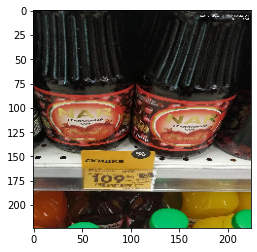

In [ ]:
plt.imshow(images[i])

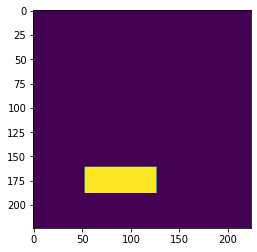

In [ ]:
plt.imshow(masks[i])

In [ ]:
X = images
y = masks

In [ ]:
# X_train = X[:100]
# X_val = X[100:150]
# X_test = X[150:]

# y_train = y[:100]
# y_val = y[100:150]
# y_test = y[150:]

In [ ]:
img_size = (224, 224)
num_classes = 1
batch_size = 4

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
# def DiceLoss(targets, inputs, smooth=1e-6):
    
#     #flatten label and prediction tensors
#     inputs = K.flatten(inputs)
#     targets = K.flatten(targets)
    
#     intersection = K.sum(K.dot(targets, inputs))
#     dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
#     return 1 - dice

In [ ]:
# def IoULoss(targets, inputs, smooth=1e-6):
    
#     #flatten label and prediction tensors
#     inputs = K.flatten(inputs)
#     targets = K.flatten(targets)
    
#     intersection = K.sum(K.dot(targets, inputs))
#     total = K.sum(targets) + K.sum(inputs)
#     union = total - intersection
    
#     IoU = (intersection + smooth) / (union + smooth)
#     return 1 - IoU

In [ ]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.compile(optimizer="rmsprop", loss=dice_coef_loss, metrics=[dice_coef])
model.fit(X, y, epochs=10)

Epoch 1/10
56/56 [==============================] - 25s 373ms/step - loss: 0.4252 - dice_coef: 0.5758
Epoch 2/10
56/56 [==============================] - 21s 377ms/step - loss: 0.2602 - dice_coef: 0.7400
Epoch 3/10
56/56 [==============================] - 21s 378ms/step - loss: 0.2030 - dice_coef: 0.7974
Epoch 4/10
56/56 [==============================] - 21s 381ms/step - loss: 0.1681 - dice_coef: 0.8322
Epoch 5/10
56/56 [==============================] - 21s 382ms/step - loss: 0.1474 - dice_coef: 0.8528
Epoch 6/10
56/56 [==============================] - 21s 384ms/step - loss: 0.1317 - dice_coef: 0.8680
Epoch 7/10
56/56 [==============================] - 22s 385ms/step - loss: 0.1197 - dice_coef: 0.8803
Epoch 8/10
56/56 [==============================] - 22s 386ms/step - loss: 0.1087 - dice_coef: 0.8914
Epoch 9/10
56/56 [==============================] - 22s 387ms/step - loss: 0.1030 - dice_coef: 0.8972
Epoch 10/10
56/56 [==============================] - 22s 387ms/step - loss: 0.0946

In [ ]:
i=502

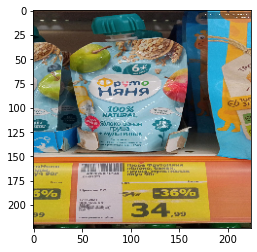

In [ ]:
plt.imshow(images[i])

In [ ]:
predict = model.predict(np.expand_dims(images[i], axis=0))[0]
predict = np.squeeze(predict, axis = 2)
predict.shape

(224, 224)

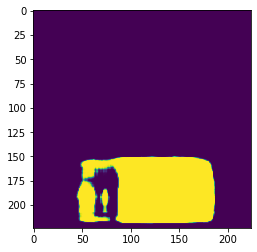

In [ ]:
plt.imshow(predict)

In [ ]:
predict.max()

1.0

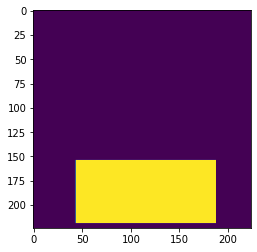

In [ ]:
plt.imshow(masks[i])